In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp

# Initialize SparkSession with legacy time parser policy
spark = SparkSession \
    .builder \
    .appName("PySparkSQL") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Define the path to the CSV file
file_path = "/home/hduser/Desktop/ProjectTweets.csv"

# Load the CSV data into a DataFrame
tweets_df = spark.read.format("csv").option("header", "false").option("inferSchema", "true").load(file_path)

# Rename the columns according to your CSV structure
tweets_df = tweets_df.withColumnRenamed("_c0", "Sequencial") \
                     .withColumnRenamed("_c1", "Serial_Number") \
                     .withColumnRenamed("_c2", "Date") \
                     .withColumnRenamed("_c3", "NO_QUERY") \
                     .withColumnRenamed("_c4", "User_Name") \
                     .withColumnRenamed("_c5", "Tweet")

# Use the old timestamp format that matches the legacy parser
old_timestamp_format = "EEE MMM dd HH:mm:ss z yyyy"
tweets_df = tweets_df.withColumn("Date", to_timestamp(tweets_df["Date"], old_timestamp_format))

# Drop the unnecessary columns
tweets_df = tweets_df.drop("Serial_Number", "NO_QUERY", "User_Name")

# Show the DataFrame to verify the columns are dropped
tweets_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/05 15:37:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/05 15:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/05 15:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/11/05 15:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


+----------+-------------------+--------------------+
|Sequencial|               Date|               Tweet|
+----------+-------------------+--------------------+
|         0|2009-04-07 06:19:45|@switchfoot http:...|
|         1|2009-04-07 06:19:49|is upset that he ...|
|         2|2009-04-07 06:19:53|@Kenichan I dived...|
|         3|2009-04-07 06:19:57|my whole body fee...|
|         4|2009-04-07 06:19:57|@nationwideclass ...|
|         5|2009-04-07 06:20:00|@Kwesidei not the...|
|         6|2009-04-07 06:20:03|         Need a hug |
|         7|2009-04-07 06:20:03|@LOLTrish hey  lo...|
|         8|2009-04-07 06:20:05|@Tatiana_K nope t...|
|         9|2009-04-07 06:20:09|@twittera que me ...|
|        10|2009-04-07 06:20:16|spring break in p...|
|        11|2009-04-07 06:20:17|I just re-pierced...|
|        12|2009-04-07 06:20:19|@caregiving I cou...|
|        13|2009-04-07 06:20:19|@octolinz16 It it...|
|        14|2009-04-07 06:20:20|@smarrison i woul...|
|        15|2009-04-07 06:20

In [2]:
# Count the total number of tweets
tweet_count = tweets_df.count()

print(f"Total number of tweets: {tweet_count}")

Total number of tweets: 1600000


In [3]:
from pyspark.sql.functions import col
nightmare_tweets = tweets_df.filter(col("Tweet").contains("nightmare"))
nightmare_tweet_count = nightmare_tweets.count()
print(f"Number of tweets containing 'nightmare': {nightmare_tweet_count}")


Number of tweets containing 'nightmare': 956


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType, StringType
from textblob import TextBlob

# Initialize SparkSession (assuming it's already started in your environment)
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Define a function to compute sentiment
def get_tweet_sentiment(tweet_text):
    # Use TextBlob to get the sentiment polarity
    analysis = TextBlob(tweet_text)
    # Set threshold for positive and negative sentiments
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

# Define the function to truncate the tweet text for better display
def truncate_string(s, length=50):
    return s if len(s) <= length else s[:length-3] + '...'

# Register the UDFs
sentiment_udf = udf(get_tweet_sentiment, IntegerType())
truncate_udf = udf(truncate_string, StringType())

# Apply the sentiment UDF to the DataFrame
tweets_df = tweets_df.withColumn('SentimentScore', sentiment_udf(col('Tweet')))

# Apply the truncation UDF to the DataFrame to shorten the tweet text
tweets_df = tweets_df.withColumn('TruncatedTweet', truncate_udf(col('Tweet')))

# Select the desired columns to show and display the DataFrame as a table, excluding 'Sequencial'
tweets_df.select('SentimentScore', 'Date', 'TruncatedTweet').show(truncate=False)

23/11/05 15:38:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------+-------------------+--------------------------------------------------+
|SentimentScore|Date               |TruncatedTweet                                    |
+--------------+-------------------+--------------------------------------------------+
|1             |2009-04-07 06:19:45|@switchfoot http://twitpic.com/2y1zl - Awww, th...|
|0             |2009-04-07 06:19:49|is upset that he can't update his Facebook by t...|
|1             |2009-04-07 06:19:53|@Kenichan I dived many times for the ball. Mana...|
|1             |2009-04-07 06:19:57|my whole body feels itchy and like its on fire    |
|-1            |2009-04-07 06:19:57|@nationwideclass no, it's not behaving at all. ...|
|1             |2009-04-07 06:20:00|@Kwesidei not the whole crew                      |
|0             |2009-04-07 06:20:03|Need a hug                                        |
|1             |2009-04-07 06:20:03|@LOLTrish hey  long time no see! Yes.. Rains a ...|
|0             |2009-04-07 06:20

## Create an Average Sentimental by Day

In [6]:
from pyspark.sql import functions as F

# Group by the date and calculate the average sentiment score, ensure the grouped date column has a simple alias
time_series_df = tweets_df.groupBy(F.to_date("Date").alias("Date")).agg(F.avg("SentimentScore").alias("AvgSentiment"))

# Sort the data by the aliased date
time_series_df = time_series_df.orderBy("Date")

# Show the DataFrame to verify the time series data
time_series_df.show()


+----------+-------------------+
|      Date|       AvgSentiment|
+----------+-------------------+
|2009-04-07| 0.2477867543902085|
|2009-04-18| 0.2785147532853955|
|2009-04-19|0.27514107514107516|
|2009-04-20| 0.2718599230227137|
|2009-04-21| 0.2747411076091851|
|2009-05-02| 0.2774954978132236|
|2009-05-03|0.27418646436414457|
|2009-05-04| 0.2695570532810247|
|2009-05-10| 0.3104497480270039|
|2009-05-11|  0.294836737976516|
|2009-05-12| 0.2646918299092212|
|2009-05-14|0.26061507014772833|
|2009-05-17| 0.2846013833272661|
|2009-05-18| 0.2942734045417826|
|2009-05-22|0.29697131485705963|
|2009-05-24|0.20710059171597633|
|2009-05-25| 0.2958579881656805|
|2009-05-27| 0.2696445477235562|
|2009-05-29| 0.2852847478254644|
|2009-05-30| 0.2877776709298971|
+----------+-------------------+
only showing top 20 rows



### Given the nature of the dataset (sentiment scores over time), We might start with LSTM to capture potential non-linear patterns. Then, we could use ARIMA as a comparison to see how a more traditional linear method performs on this data.

In [7]:
# Assuming you have the PySpark DataFrame named `time_series_df`
pandas_df = time_series_df.toPandas()

In [8]:
# Save the DataFrame to a CSV file
pandas_df.to_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv', index=False)

In [9]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt  # Import the datetime module

# Assuming 'dataset' is a pandas DataFrame that includes 'Date' and 'AvgSentiment'
# Convert date to ordinal to represent it numerically
dataset['Date'] = pd.to_datetime(dataset['Date']).map(dt.datetime.toordinal)

# Scale the AvgSentiment values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['AvgSentiment'].values.reshape(-1, 1))

# Create the time steps for LSTM (let's assume we're using 5 days to predict the next day)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 5
X, y = create_dataset(scaled_data, time_step)

# The rest of your LSTM code would go here
# ...

# Make sure to reshape 'X' to be [samples, time steps, features] which is required for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

In [102]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Load your data here
# df = pd.read_csv('path_to_your_data.csv')

# Preprocess your data and split into features and labels
# X, y = preprocess_data(df)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling - Make sure X_train and X_test are 2D before this step
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape if necessary to ensure the data is 2D
if len(X_train.shape) > 2:
    # Assuming the 3rd dimension is the features and we're keeping the first dimension intact
    X_train_reshaped_for_scaling = X_train.reshape((X_train.shape[0], -1))
    X_test_reshaped_for_scaling = X_test.reshape((X_test.shape[0], -1))
else:
    X_train_reshaped_for_scaling = X_train
    X_test_reshaped_for_scaling = X_test

# Apply scaling
X_train_scaled = scaler.fit_transform(X_train_reshaped_for_scaling)
X_test_scaled = scaler.transform(X_test_reshaped_for_scaling)

# Reshape the scaled data back to 3D if necessary for LSTM input
if len(X_train.shape) > 2:
    Timesteps = X_train.shape[1]  # Replace with your actual timesteps if necessary
    Features = X_train.shape[2]   # Replace with your actual features if necessary
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], Timesteps, Features))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], Timesteps, Features))
else:
    # Replace 1 with your actual timesteps if necessary
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, -1))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, -1))

# Define the LSTM model with bidirectional layer
model = Sequential()
model.add(Bidirectional(LSTM(units=64, activation='relu',
                             input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]),
                             kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                             bias_regularizer=regularizers.l2(1e-4),
                             activity_regularizer=regularizers.l2(1e-5))))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

# Define the optimizer with a learning rate schedule
optimizer = Adam(learning_rate=0.001)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping callback to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model with the new callbacks
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_schedule, model_checkpoint],
    verbose=1
)

# Load the best weights
model.load_weights('model.h5')

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test loss: {test_loss}")


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.4786 - val_loss: 0.4083 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 170ms/step - loss: 0.4704 - val_loss: 0.3870 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 146ms/step - loss: 0.4422 - val_loss: 0.3668 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 150ms/step - loss: 0.4174 - val_loss: 0.3473 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 182ms/step - loss: 0.4007 - val_loss: 0.3285 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 199ms/step - loss: 0.3640 - val_loss: 0.3103 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 140ms/step - loss: 0.3496 - val_loss: 0.2928 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 130ms/step - loss: 0.3383 - val_loss: 0.2760 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 163ms/step - loss: 0.3266 - val_loss: 0.2597 - lr: 0.

Validation Loss vs. Training Loss

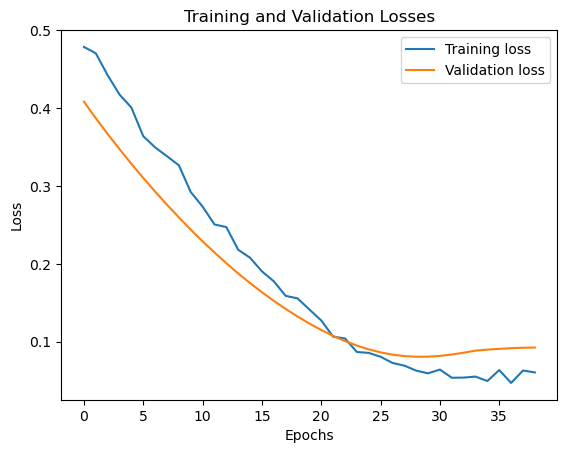

In [103]:
import matplotlib.pyplot as plt

# Assuming history is the output from the fit function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [104]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared on Test Data: {r2}")


1/1 [==============================] - 0s 226ms/step
Mean Squared Error on Test Data: 0.053795886553328225
R-squared on Test Data: 0.31023964433337037


1/1 [==============================] - 0s 59ms/step


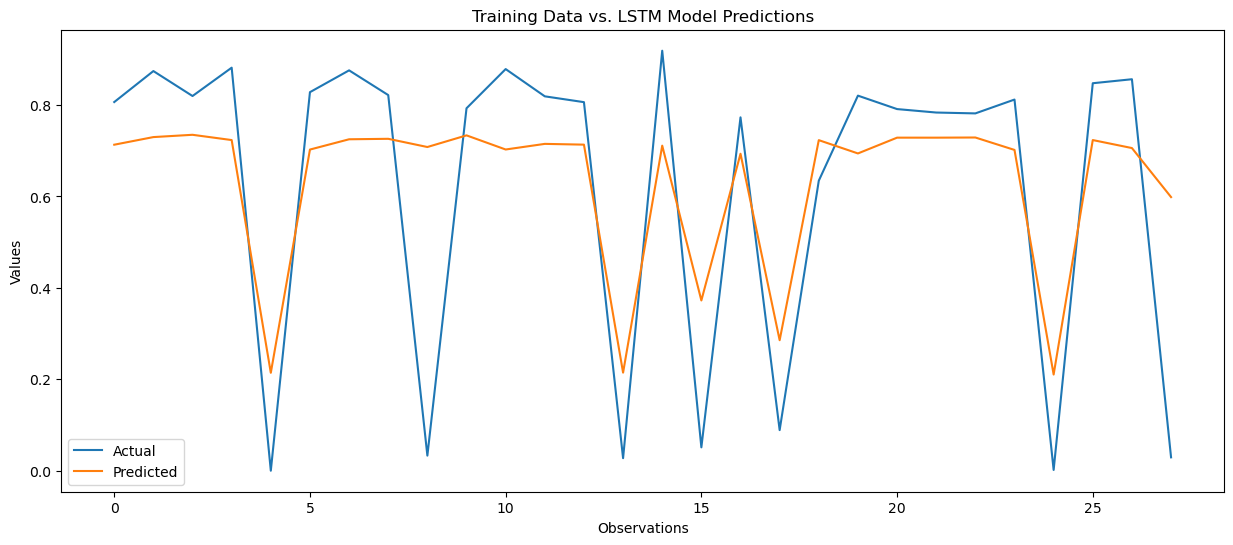

In [118]:
# Generate predictions for the training set
y_train_pred = model.predict(X_train_reshaped)

# Rescale the predictions back to the original scale if you have scaled the target variable
# If the target variable was scaled, you should apply the inverse transformation to y_train_pred and y_train

# Plot the training data against the predicted values
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.title('Training Data vs. LSTM Model Predictions')
plt.xlabel('Observations')
plt.ylabel('Values')
plt.legend()
plt.show()


# Train/Test using Time-Series

In [312]:
# Load the dataset from CSV file or other source where 'Date' is present
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

In [313]:
# Print the column names of the dataset to verify that 'Date' exists
print(dataset.columns)

Index(['Date', 'AvgSentiment'], dtype='object')


In [314]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

# Convert 'Date' to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Normalize 'AvgSentiment' values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['AvgSentiment'] = scaler.fit_transform(dataset['AvgSentiment'].values.reshape(-1,1))

# Convert 'Date' to integer
dataset['Date'] = dataset['Date'].map(pd.Timestamp.toordinal)

# Create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # take n_steps values
        y.append(data[i, 0])  # take the next value
    return np.array(X), np.array(y)

n_steps = 5  # number of steps to look back (this can be tuned)
X, y = create_sequences(dataset[['AvgSentiment']].values, n_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [315]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


2023-11-06 13:41:28.410088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:28.412279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:28.413888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_37 (LSTM)              (None, 50)                20200     
                                                                 
 dense_22 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


2023-11-06 13:41:29.363974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:29.366333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:29.367745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [316]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100


2023-11-06 13:41:30.539859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:30.542941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:30.544952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 9s 9s/step - loss: 0.5461
Epoch 2/100
1/1 [==============================] - 0s 105ms/step - loss: 0.5032
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.4623
Epoch 4/100
1/1 [==============================] - 0s 82ms/step - loss: 0.4231
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.3855
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.3490
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 0.3137
Epoch 8/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2793
Epoch 9/100
1/1 [==============================] - 0s 53ms/step - loss: 0.2460
Epoch 10/100
1/1 [==============================] - 0s 33ms/step - loss: 0.2138
Epoch 11/100
1/1 [==============================] - 0s 52ms/step - loss: 0.1830
Epoch 12/100
1/1 [==============================] - 0s 75ms/step - loss: 0.1541
Epoch 13/100
1/1 [==============================] - 0s 10ms/st

In [317]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_pred_inverted = scaler.inverse_transform(y_pred)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1,1))


2023-11-06 13:41:43.306218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:43.308444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:43.309767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


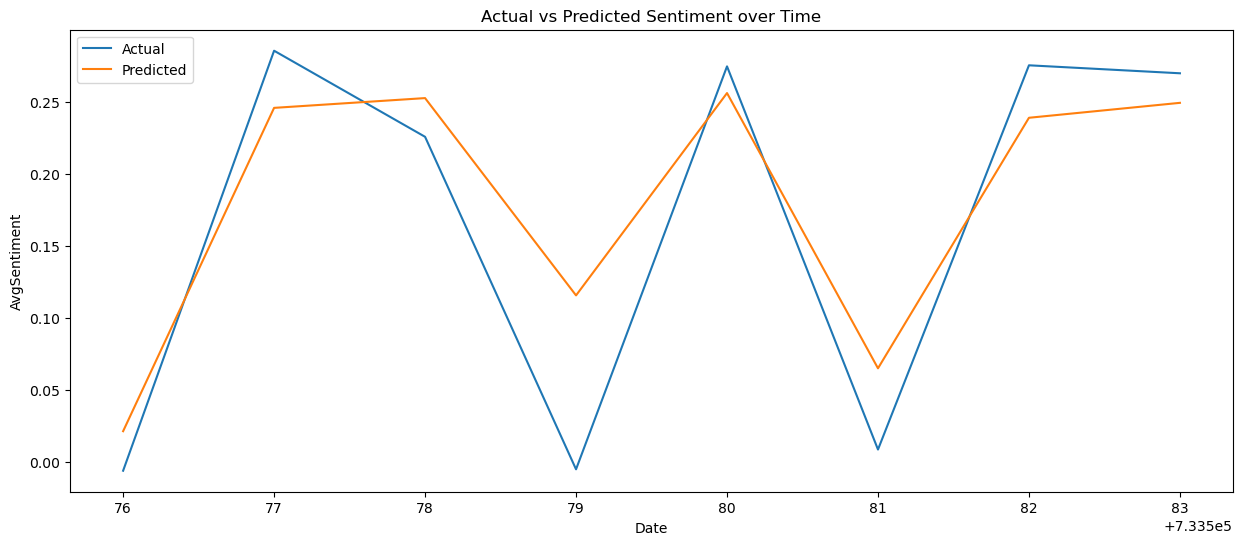

In [318]:
import matplotlib.pyplot as plt

# Extract the last n_steps dates for the test set (since we used them for creating the sequences)
test_dates = dataset['Date'][-len(y_test):]

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_inverted, label='Actual')
plt.plot(test_dates, y_pred_inverted, label='Predicted')
plt.title('Actual vs Predicted Sentiment over Time')
plt.xlabel('Date')
plt.ylabel('AvgSentiment')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming history is the output from the fit function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [319]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
y_pred = model.predict(X_test)

# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error on Test Data: {mse}")
print(f"R-squared on Test Data: {r2}")


1/1 [==============================] - 0s 69ms/step
Mean Squared Error on Test Data: 0.02160024786867208
R-squared on Test Data: 0.8317123760259189


In [320]:
# Forecast future steps, one day at a time
def forecast(model, initial_sequence, n_forecast, n_features):
    forecast_results = []
    current_sequence = initial_sequence.reshape(-1, n_features)
    for _ in range(n_forecast):
        # Predict the next step and retrieve the numerical value
        next_step = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        # Append the prediction to the results
        forecast_results.append(next_step)
        # Add the prediction to the input sequence for the next forecast
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_step
    return np.array(forecast_results)

# Assuming your data has a single feature per step
n_features = 1

# Perform the forecasts
forecast_7_days = forecast(model, X_test[-1], 7, n_features)
forecast_1_month = forecast(model, X_test[-1], 30, n_features)
forecast_3_months = forecast(model, X_test[-1], 90, n_features)

# Inverse transform forecasts to original scale
forecast_7_days_inverted = scaler.inverse_transform(forecast_7_days.reshape(-1, 1))
forecast_1_month_inverted = scaler.inverse_transform(forecast_1_month.reshape(-1, 1))
forecast_3_months_inverted = scaler.inverse_transform(forecast_3_months.reshape(-1, 1))


1/1 [==============================] - 0s 17ms/step


In [321]:
def plot_forecast(train_data, test_data, forecast_data, title):
    plt.figure(figsize=(14, 7))
    
    # Plot train data
    train_len = len(train_data)
    plt.plot(range(train_len), train_data, color='blue', label='Train data')
    
    # Plot test data
    test_len = len(test_data)
    plt.plot(range(train_len, train_len + test_len), test_data, color='orange', label='Test data')
    
    # Plot forecast data
    forecast_len = len(forecast_data)
    plt.plot(range(train_len + test_len, train_len + test_len + forecast_len), forecast_data, color='green', label='Forecast')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


2023-11-06 13:41:56.834880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:56.838287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:56.840390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-11-06 13:41:57.291801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:41:57.308992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:41:57.317327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 6s 6s/step - loss: 0.5570
Epoch 2/100
1/1 [==============================] - 0s 80ms/step - loss: 0.5071
Epoch 3/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4596
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 0.4141
Epoch 5/100
1/1 [==============================] - 0s 22ms/step - loss: 0.3703
Epoch 6/100
1/1 [==============================] - 0s 55ms/step - loss: 0.3282
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.2878
Epoch 8/100
1/1 [==============================] - 0s 57ms/step - loss: 0.2491
Epoch 9/100
1/1 [==============================] - 0s 68ms/step - loss: 0.2123
Epoch 10/100
1/1 [==============================] - 0s 61ms/step - loss: 0.1778
Epoch 11/100
1/1 [==============================] - 0s 58ms/step - loss: 0.1461
Epoch 12/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1179
Epoch 13/100
1/1 [==============================] - 0s 86ms/ste

2023-11-06 13:42:07.431167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 13:42:07.455393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 13:42:07.461340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 50ms/step


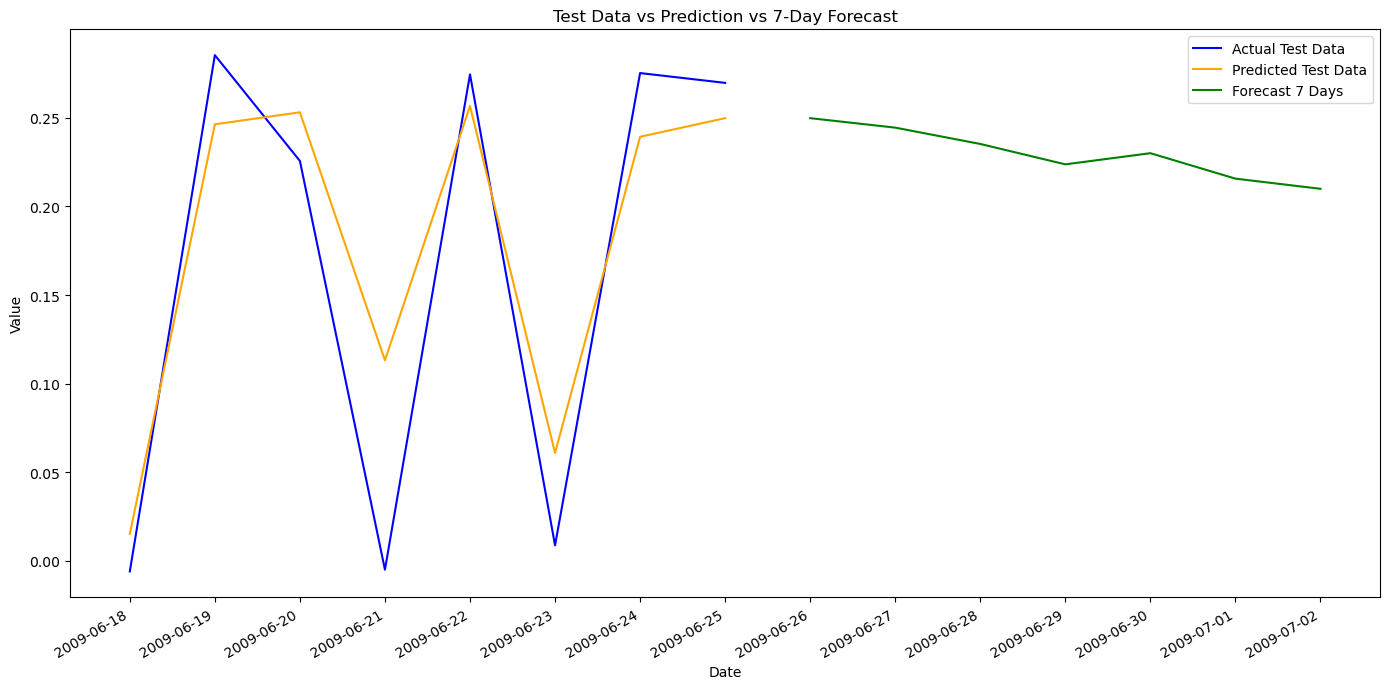

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

# Convert 'Date' to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Normalize 'AvgSentiment' values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset['AvgSentiment'] = scaler.fit_transform(dataset['AvgSentiment'].values.reshape(-1,1))

# Convert 'Date' to integer (ordinal)
dataset['Date'] = dataset['Date'].map(pd.Timestamp.toordinal)

# Create sequences for LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 5
X, y = create_sequences(dataset[['AvgSentiment']].values, n_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and test labels
y_pred_inverted = scaler.inverse_transform(y_pred)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Forecast future steps
forecast_7_days = forecast(model, X_test[-1], 7, n_features=1)
forecast_7_days_inverted = scaler.inverse_transform(forecast_7_days.reshape(-1, 1))

# Extract the last n_steps dates for the test set (as ordinal dates)
test_dates_ord = dataset['Date'][-len(y_test_inverted):].values

# Define a function to plot forecast alongside actual test data
def plot_test_vs_prediction_vs_forecast(test_dates_ord, test_actual, test_predicted, forecast, title):
    plt.figure(figsize=(14, 7))
    
    # Convert ordinal dates back to timestamps
    test_dates = [pd.Timestamp.fromordinal(int(date)) for date in test_dates_ord]
    forecast_dates = [test_dates[-1] + pd.Timedelta(days=i) for i in range(1, len(forecast) + 1)]
    all_dates = test_dates + forecast_dates
    
    # Plot actual test data
    plt.plot(test_dates, test_actual, color='blue', label='Actual Test Data')
    
    # Plot predicted test data
    plt.plot(test_dates, test_predicted, color='orange', label='Predicted Test Data')
    
    # Plot forecast data
    plt.plot(forecast_dates, forecast, color='green', label='Forecast 7 Days')
    
    # Formatting plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_test_vs_prediction_vs_forecast(
    test_dates_ord, 
    y_test_inverted, 
    y_pred_inverted, 
    forecast_7_days_inverted, 
    'Test Data vs Prediction vs 7-Day Forecast'
)


1/1 [==============================] - 0s 19ms/step


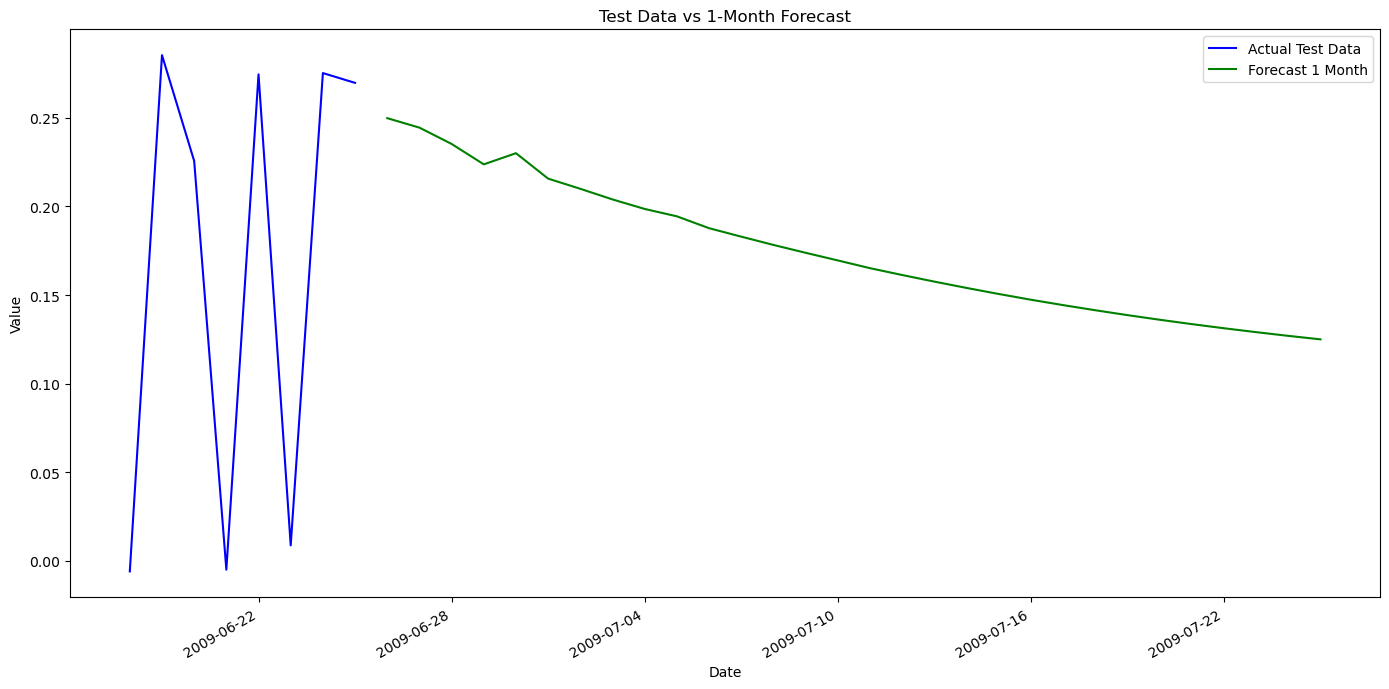

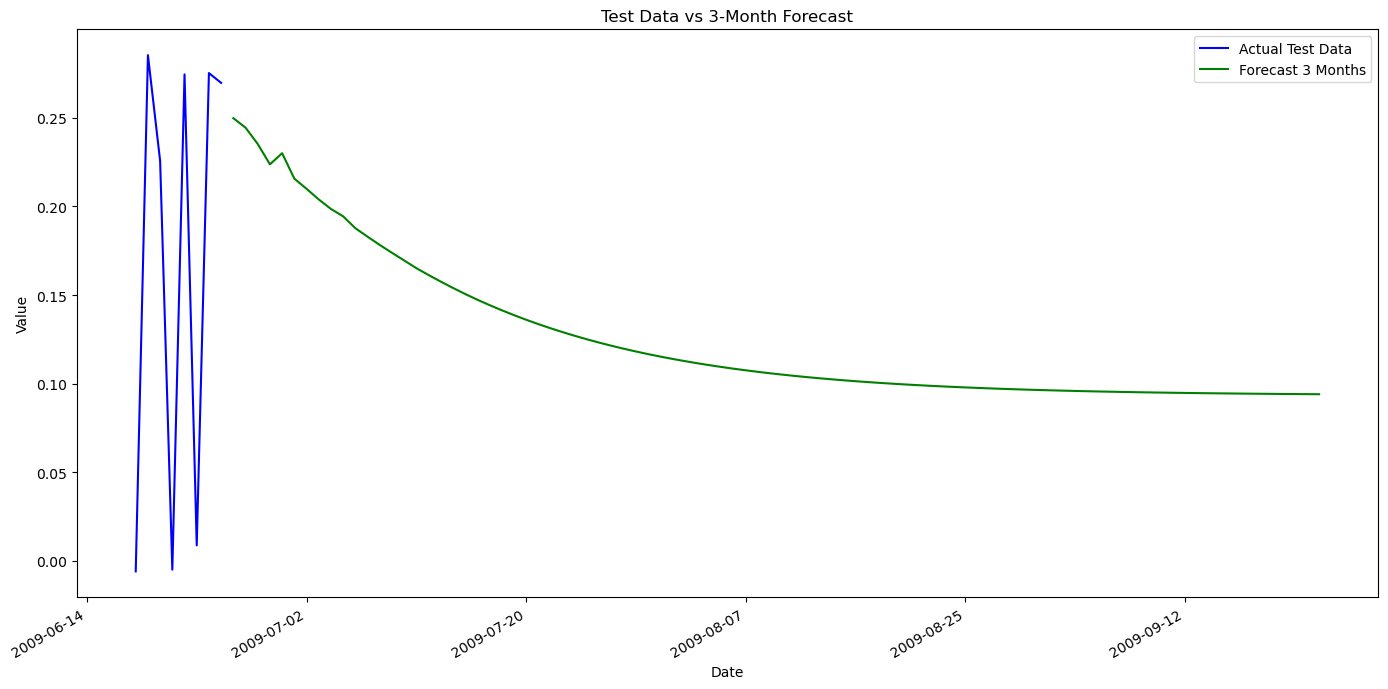

In [323]:
# Forecast for 1 month (approx. 30 days)
forecast_1_month = forecast(model, X_test[-1], 30, n_features=1)
forecast_1_month_inverted = scaler.inverse_transform(forecast_1_month.reshape(-1, 1))

# Forecast for 3 months (approx. 90 days)
forecast_3_months = forecast(model, X_test[-1], 90, n_features=1)
forecast_3_months_inverted = scaler.inverse_transform(forecast_3_months.reshape(-1, 1))

# Function to plot
def plot_forecast(test_dates_ord, test_actual, forecast, forecast_period, title):
    plt.figure(figsize=(14, 7))
    
    # Convert ordinal dates back to timestamps for test data
    test_dates = [pd.Timestamp.fromordinal(int(date)) for date in test_dates_ord]
    # Generate forecast dates
    forecast_dates = [test_dates[-1] + pd.Timedelta(days=i) for i in range(1, len(forecast) + 1)]
    
    # Plot actual test data
    plt.plot(test_dates, test_actual, color='blue', label='Actual Test Data')
    
    # Plot forecast data
    plt.plot(forecast_dates, forecast, color='green', label=f'Forecast {forecast_period}')
    
    # Formatting plot
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=int(len(forecast_dates)/5)))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

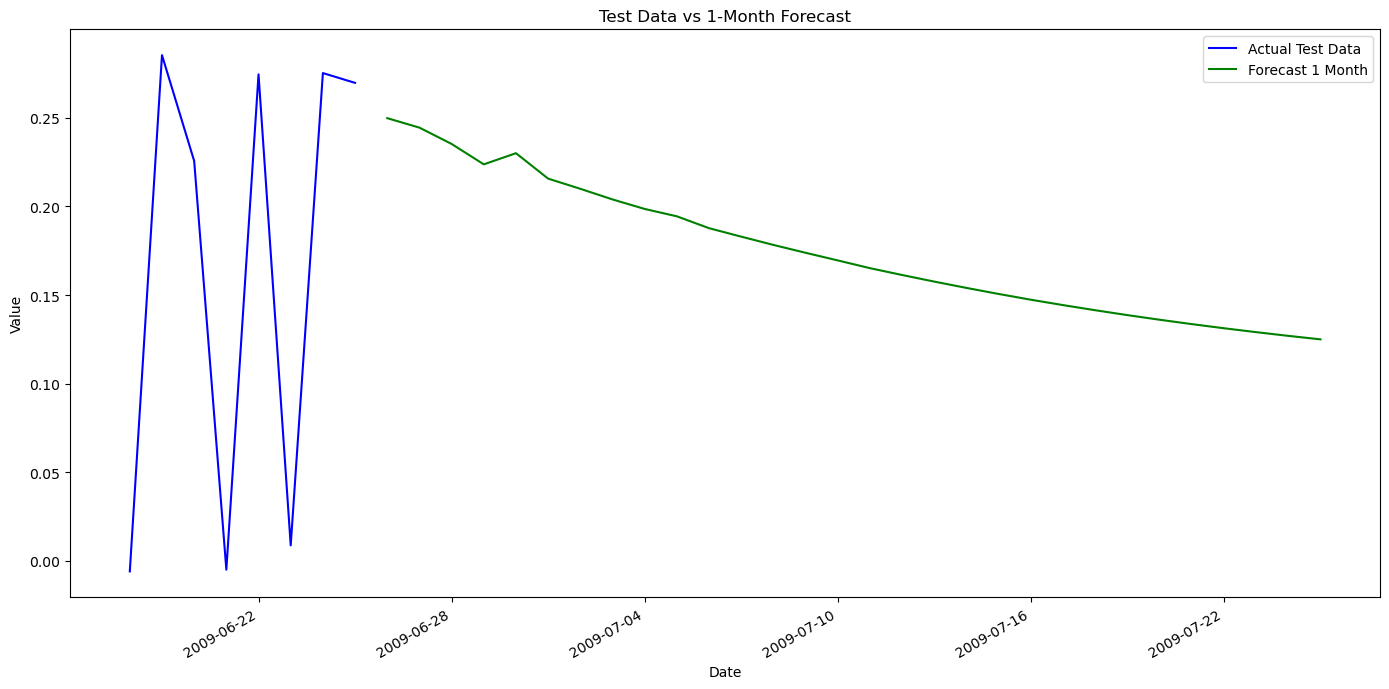

In [379]:
# Plot for 1 month forecast
plot_forecast(
    test_dates_ord, 
    y_test_inverted, 
    forecast_1_month_inverted, 
    "1 Month", 
    'Test Data vs 1-Month Forecast'
)

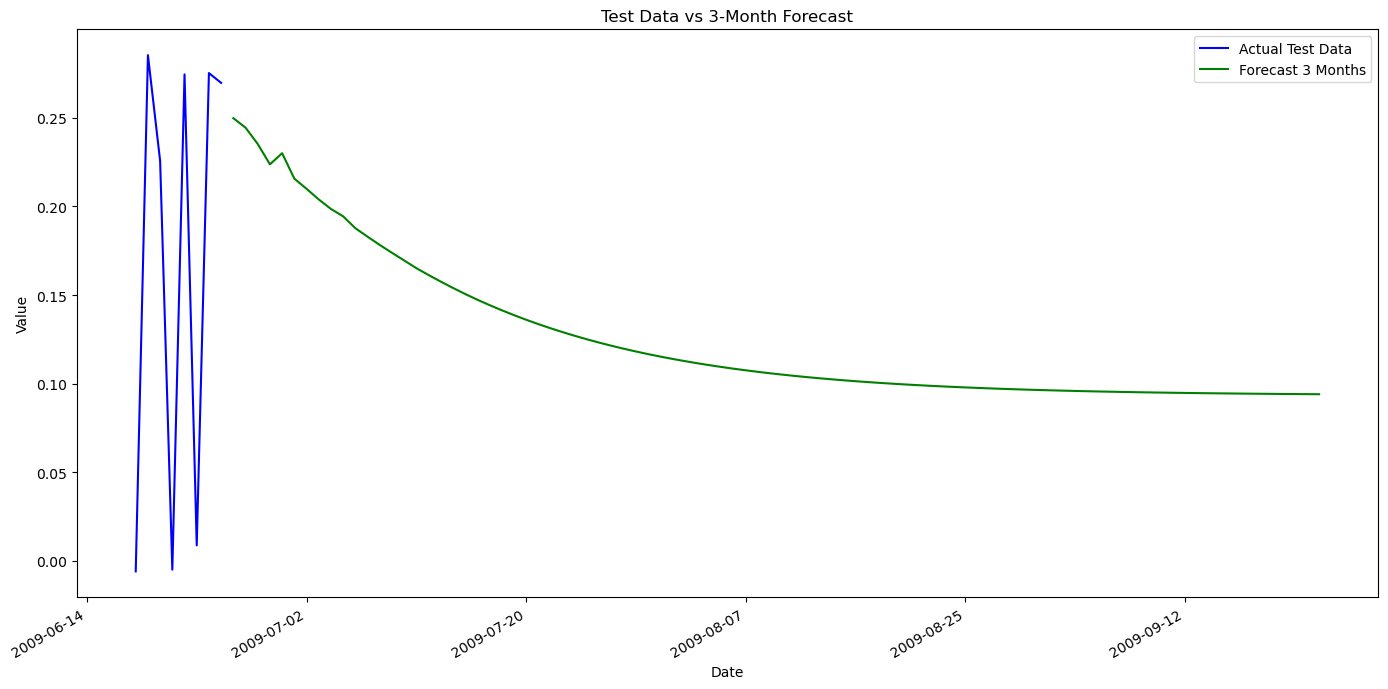

In [380]:
# Plot for 3 months forecast
plot_forecast(
    test_dates_ord, 
    y_test_inverted, 
    forecast_3_months_inverted, 
    "3 Months", 
    'Test Data vs 3-Month Forecast'
)

# ARIMA 

In [285]:
# Load the dataset from CSV file or other source where 'Date' is present
dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')

In [286]:
# Print the column names of the dataset to verify that 'Date' exists
print(dataset.columns)

Index(['Date', 'AvgSentiment'], dtype='object')


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-260.776, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-255.038, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-260.479, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-251.034, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-262.761, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-264.754, Time=0.08 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-262.753, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-253.026, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-262.476, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=-261.599, Time=0.20 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-258.362, Time=0.11 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=-251.031, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=-262.305, Time=0.14 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]

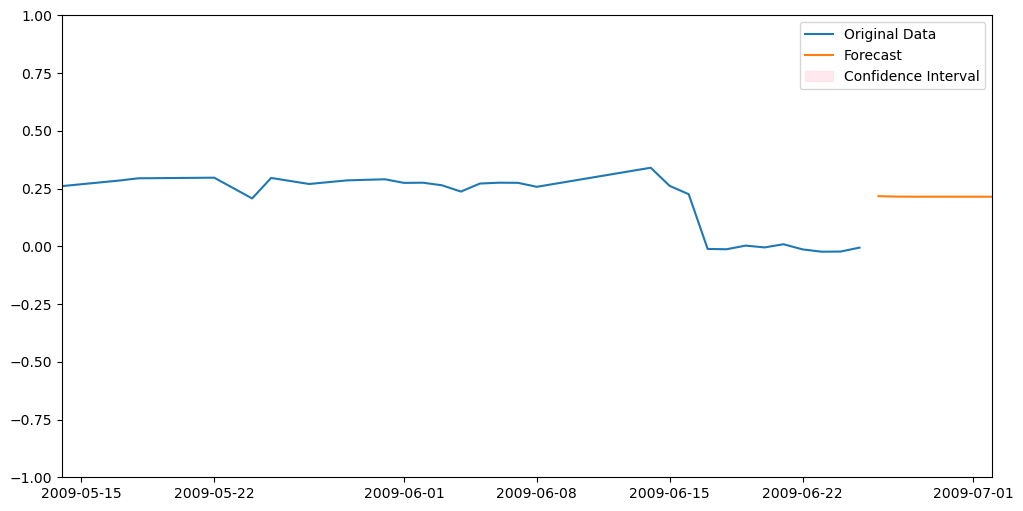

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Load the dataset

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)

# Apply min-max scaling to bring the sentiment scores to the range [0, 1]
dataset['AvgSentiment_Scaled'] = (dataset['AvgSentiment'] + 1) / 2

# Transform the scaled data with Box-Cox
dataset['Transformed'], lambda_ = boxcox(dataset['AvgSentiment_Scaled'])

# Split the data into train and test
train_size = int(len(dataset) * 0.8)
train, test = dataset['Transformed'][:train_size], dataset['Transformed'][train_size:]

# Fit ARIMA model on the training set
stepwise_fit = auto_arima(train, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# Fit the ARIMA model using the best parameters found
model = ARIMA(train, order=stepwise_fit.order)
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Inverse Box-Cox and min-max scaling to bring back to the [-1, 1] range
forecast_mean_original_scale = inv_boxcox(forecast_mean, lambda_) * 2 - 1
train_original_scale = inv_boxcox(train, lambda_) * 2 - 1
test_original_scale = inv_boxcox(test, lambda_) * 2 - 1

# Assume we are forecasting 7 days ahead
forecast_days = 7

# Fit the ARIMA model using the best parameters found
model = ARIMA(train, order=stepwise_fit.order)
results = model.fit()

# Forecast for the next 7 days
forecast = results.get_forecast(steps=forecast_days)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Inverse transformations to return to original scale
forecast_mean_original_scale = inv_boxcox(forecast_mean, lambda_) * 2 - 1
lower_bound = inv_boxcox(forecast_conf_int.iloc[:, 0], lambda_) * 2 - 1
upper_bound = inv_boxcox(forecast_conf_int.iloc[:, 1], lambda_) * 2 - 1

# Dates for forecasting
last_date = dataset.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_days + 1, freq='D')[1:]  # Exclude the start date and set frequency to daily

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['AvgSentiment'], label='Original Data')
plt.plot(forecast_dates, forecast_mean_original_scale, label='Forecast')
plt.fill_between(forecast_dates, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Interval')
plt.xlim([dataset.index[-30], forecast_dates[-1]])  # Limit the x-axis to the last 30 days and the forecast period
plt.ylim(-1, 1)  # Ensure the y-axis is between -1 and 1
plt.legend()
plt.show()

# Dashboard Dash.

In [381]:
# Save LSTM model
model.save('lstm_model.h5')

# Save the MinMaxScaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [383]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from keras.models import load_model
import joblib
import plotly.graph_objs as go
import pandas as pd
from datetime import timedelta
import numpy as np

# Load the LSTM model and scaler
model = load_model('lstm_model.h5')
scaler = joblib.load('scaler.pkl')

# Define the get_last_sequence function
def get_last_sequence(dataset, n_steps=5):
    # Assuming that 'AvgSentiment' is the feature we're forecasting
    last_points = dataset['AvgSentiment'].values[-n_steps:].reshape(-1, 1)
    return last_points

# Define the preprocess_sequence function
def preprocess_sequence(last_sequence, scaler, n_steps=5):
    # Scale the last sequence
    last_sequence_scaled = scaler.transform(last_sequence)
    # Reshape it to the required input shape [samples, time steps, features]
    last_sequence_reshaped = last_sequence_scaled.reshape(1, n_steps, 1)
    return last_sequence_reshaped

# Initialize the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    # Dropdown menu for selecting the forecast horizon
    dcc.Dropdown(
        id='forecast-horizon-dropdown',
        options=[
            {'label': '7 Days', 'value': 7},
            {'label': '1 Month', 'value': 30},
            {'label': '3 Months', 'value': 90}
        ],
        value=7  # Default value
    ),
    # Graph to display the actual vs predicted values and forecast
    dcc.Graph(id='forecast-graph')
])

@app.callback(
    Output('forecast-graph', 'figure'),
    [Input('forecast-horizon-dropdown', 'value')]
)
def update_graph(forecast_horizon):
    # Load your dataset
    dataset = pd.read_csv('/home/hduser/Desktop/tweet_sentiment_time_series.csv')
    dataset['Date'] = pd.to_datetime(dataset['Date'])

    # Get the last sequence from the dataset for the forecast
    last_sequence = get_last_sequence(dataset, n_steps=5)

    # Initialize the predictions list
    predictions = []

    # Start the prediction loop
    for _ in range(forecast_horizon):
        # Preprocess the last sequence for the model
        last_sequence_processed = preprocess_sequence(last_sequence, scaler, n_steps=5)

        # Predict the next step
        prediction_scaled = model.predict(last_sequence_processed)
        prediction = scaler.inverse_transform(prediction_scaled).flatten()[0]

        # Append the prediction to the predictions list
        predictions.append(prediction)

        # Update the last sequence with the new prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = prediction_scaled

    # Generate dates for forecasting
    last_date = dataset['Date'].iloc[-1]
    forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_horizon + 1)]

    # Ensure the predictions are a flat list with the correct number of forecasts
    predictions = predictions[:forecast_horizon]

    # Create traces for actual data and forecast
    actual_trace = go.Scatter(x=dataset['Date'], y=dataset['AvgSentiment'], mode='lines', name='Actual')
    forecast_trace = go.Scatter(x=forecast_dates, y=predictions, mode='lines', name='Forecast')

    # Return the graph with actual and forecast traces
    return {
        'data': [actual_trace, forecast_trace],
        'layout': go.Layout(
            title='Sentiment Forecast',
            xaxis={'title': 'Date'},
            yaxis={'title': 'Sentiment Value'}
        )
    }

2023-11-06 17:10:21.320682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 17:10:21.373622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 17:10:21.458950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
from keras.models import load_model
import numpy as np

# Load the LSTM model
model = load_model('lstm_model.h5')

# Construct a sample input that matches the shape the model expects
# For example, if your model expects 5 time steps with 1 feature:
sample_input = np.array([[[0.1], [0.2], [0.3], [0.4], [0.5]]])  # Replace with your actual scaled input

# Perform a prediction
sample_prediction = model.predict(sample_input)
print("Sample Prediction:", sample_prediction)


2023-11-06 17:11:17.594184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-06 17:11:17.603811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-06 17:11:17.610252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 19s 19s/step


In [385]:
import joblib

# Load the MinMaxScaler
scaler = joblib.load('scaler.pkl')

# Scale a sample data point
sample_data_point = np.array([[0.5]])  # Replace with your actual data point
scaled_data_point = scaler.transform(sample_data_point)
print("Scaled Data Point:", scaled_data_point)

# Inverse transform the scaled data point
inverse_scaled_data_point = scaler.inverse_transform(scaled_data_point)
print("Inverse Scaled Data Point:", inverse_scaled_data_point)


Scaled Data Point: [[1.44018252]]
Inverse Scaled Data Point: [[0.5]]
